In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


BASE_DIR = os.getcwd()   # current notebook directory

DES_PATH = os.path.join(BASE_DIR, "des_mri.py")

PATHS = {
    "type1_params": os.path.join(BASE_DIR, "type1_params.csv"),
    "type2_daily":  os.path.join(BASE_DIR, "type2_daily_arrivals.csv"),
    "type2_dur":    os.path.join(BASE_DIR, "type2_durations_min.csv"),
    "meta":         os.path.join(BASE_DIR, "simulation_metadata.csv"),
}

# Safety checks
assert os.path.exists(DES_PATH), f"Missing des_mri.py at {DES_PATH}"
for k, v in PATHS.items():
    assert os.path.exists(v), f"Missing file: {k} -> {v}"

print("All files found in:", BASE_DIR)


All files found in: /Users/mustafaalpercikan/PycharmProjects/Skills-Assignment


In [28]:
import importlib.util
import sys

spec = importlib.util.spec_from_file_location("des_mri", DES_PATH)
des_mri = importlib.util.module_from_spec(spec)
sys.modules["des_mri"] = des_mri
spec.loader.exec_module(des_mri)

print("Loaded des_mri from:", DES_PATH)


Loaded des_mri from: /Users/mustafaalpercikan/PycharmProjects/Skills-Assignment/des_mri.py


In [29]:
inputs_base = des_mri.load_inputs_from_csv(
    type1_params_csv=PATHS["type1_params"],
    type2_daily_arrivals_csv=PATHS["type2_daily"],
    type2_durations_csv=PATHS["type2_dur"],
    metadata_csv=PATHS["meta"],
    seed=42
)

inputs_base


Inputs(lambda_per_day=16.952380952380953, mu_duration_min=25.71238982703046, sigma_duration_min=5.83616210083606, type2_daily_arrivals=array([11, 10, 10, 11, 10, 11,  9,  9, 10, 10, 11,  9, 11, 10,  9,  9,  8,
       11, 10, 10, 10]), type2_durations_min=array([45.39201164, 35.79678651, 49.5070169 , 42.35983315, 38.63741356,
       34.04468674, 36.24278378, 58.41052379, 24.59457586, 52.67373321,
       33.04148224, 34.44911954, 48.45925508, 42.27174469, 40.93789759,
       26.18313048, 29.6403769 , 39.8461448 , 39.0420138 , 33.49844964,
       35.85455934, 52.65259134, 37.39959938, 67.46239816, 38.97469965,
       30.67000843, 24.37691321, 37.25513709, 37.75477845, 37.20356231,
       34.4438115 , 20.5147766 , 44.25158567, 60.46276877, 52.70288071,
       36.07860202, 37.81916642, 26.27443323, 43.18953516, 38.1353278 ,
       36.86470666, 36.2108776 , 39.66615888, 35.50496175, 44.67645843,
       35.13811915, 42.83331955, 34.77451493, 40.429751  , 33.99416241,
       40.51216025, 45.98

In [30]:
def with_slots(inputs: des_mri.Inputs, slot1: int, slot2: int, seed: int) -> des_mri.Inputs:
    # Create a new Inputs object with modified slots and seed
    return des_mri.Inputs(
        lambda_per_day=inputs.lambda_per_day,
        mu_duration_min=inputs.mu_duration_min,
        sigma_duration_min=inputs.sigma_duration_min,
        type2_daily_arrivals=inputs.type2_daily_arrivals,
        type2_durations_min=inputs.type2_durations_min,
        slot_minutes_type1=int(slot1),
        slot_minutes_type2=int(slot2),
        work_minutes=inputs.work_minutes,
        seed=int(seed),
    )


In [31]:
SLOTS = {
    "q90": {"type1": 35, "type2": 45},  # <-- replace with your computed q90 rounded values
    "q95": {"type1": inputs_base.slot_minutes_type1, "type2": inputs_base.slot_minutes_type2},
}

SCENARIOS = [
    ("old", "q90"),
    ("old", "q95"),
    ("new", "q90"),
    ("new", "q95"),
]

SCENARIOS


[('old', 'q90'), ('old', 'q95'), ('new', 'q90'), ('new', 'q95')]

In [32]:
def run_one(policy: str, slot_label: str, n_workdays: int, seed: int):
    slot1 = SLOTS[slot_label]["type1"]
    slot2 = SLOTS[slot_label]["type2"]
    inp = with_slots(inputs_base, slot1, slot2, seed=seed)

    patients_df, daily_machine_df = des_mri.run_simulation(
        inputs=inp,
        n_workdays=n_workdays,
        policy=policy
    )
    return inp, patients_df, daily_machine_df

# quick test
inp_test, p_test, d_test = run_one("old", "q95", n_workdays=30, seed=1)
(len(p_test), d_test.head())


(789,
    machine_id  n_scans    busy_min  finish_min  overtime_min  utilization  \
 0           0        0    0.000000    0.000000           0.0     0.000000   
 1           1        0    0.000000    0.000000           0.0     0.000000   
 2           0       13  318.764899  507.086839           0.0     0.590305   
 3           1        8  330.430007  522.941345           0.0     0.611907   
 4           0       13  348.129273  510.685630           0.0     0.644684   
 
    day_index  
 0          0  
 1          0  
 2          1  
 3          1  
 4          2  )

In [33]:
def compute_kpis(patients_df: pd.DataFrame, daily_machine_df: pd.DataFrame) -> dict:
    w = patients_df["wait_workdays"].to_numpy() if len(patients_df) else np.array([0.0])

    overtime_per_day = daily_machine_df.groupby("day_index")["overtime_min"].sum().to_numpy()

    util_by_machine = daily_machine_df.groupby("machine_id")["utilization"].mean()

    return {
        "n_patients": int(len(patients_df)),
        "wait_mean": float(np.mean(w)),
        "wait_median": float(np.median(w)),
        "wait_p90": float(np.quantile(w, 0.90)),
        "wait_p95": float(np.quantile(w, 0.95)),
        "p_wait_le_2": float(np.mean(w <= 2)),
        "p_wait_le_5": float(np.mean(w <= 5)),
        "p_overtime": float(np.mean(overtime_per_day > 0)),
        "overtime_mean_min": float(np.mean(overtime_per_day)),
        "overtime_p95_min": float(np.quantile(overtime_per_day, 0.95)),
        "util_m0": float(util_by_machine.get(0, 0.0)),
        "util_m1": float(util_by_machine.get(1, 0.0)),
    }


In [34]:
N_WORKDAYS = 250
SEED = 123

rows = []
scenario_outputs = {}

for policy, slot_label in SCENARIOS:
    inp, patients, daily = run_one(policy, slot_label, n_workdays=N_WORKDAYS, seed=SEED)
    kpis = compute_kpis(patients, daily)

    rows.append({
        "policy": policy,
        "slot": slot_label,
        "slot_type1": inp.slot_minutes_type1,
        "slot_type2": inp.slot_minutes_type2,
        **kpis
    })

    scenario_outputs[(policy, slot_label)] = (inp, patients, daily)

results_df = pd.DataFrame(rows).sort_values(["policy", "slot"]).reset_index(drop=True)
results_df


,policy,slot,slot_type1,slot_type2,n_patients,wait_mean,wait_median,wait_p90,wait_p95,p_wait_le_2,p_wait_le_5,p_overtime,overtime_mean_min,overtime_p95_min,util_m0,util_m1
0,new,q90,35,45,6801,1.000000,1.0,1.0,1.0,1.000000,1.000000,0.068,2.370951,6.432871,0.810653,0.755824
1,new,q95,40,65,6829,1.000439,1.0,1.0,1.0,1.000000,1.000000,0.096,2.801250,19.199489,0.813965,0.756990
2,old,q90,35,45,6791,13.653217,10.0,36.0,38.0,0.376970,0.435724,0.004,0.081716,0.000000,0.715425,0.736397
3,old,q95,40,65,6855,39.659373,39.0,72.0,78.0,0.014734,0.060102,0.000,0.000000,0.000000,0.614849,0.598361


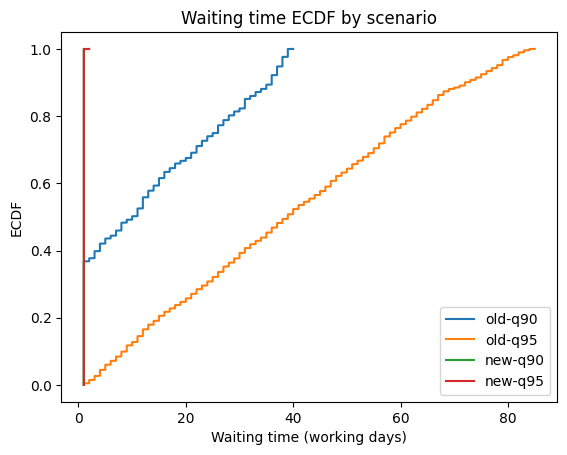

In [35]:
def plot_ecdf(wait_values, label):
    x = np.sort(wait_values)
    y = np.arange(1, len(x) + 1) / len(x)
    plt.plot(x, y, label=label)

plt.figure()
for (policy, slot_label), (_, patients, _) in scenario_outputs.items():
    w = patients["wait_workdays"].to_numpy()
    plot_ecdf(w, f"{policy}-{slot_label}")

plt.xlabel("Waiting time (working days)")
plt.ylabel("ECDF")
plt.title("Waiting time ECDF by scenario")
plt.legend()
plt.show()


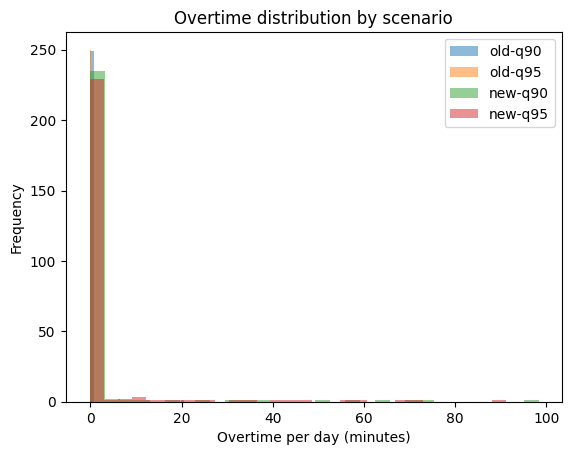

In [36]:
plt.figure()
for (policy, slot_label), (_, _, daily) in scenario_outputs.items():
    ot = daily.groupby("day_index")["overtime_min"].sum().to_numpy()
    plt.hist(ot, bins=30, alpha=0.5, label=f"{policy}-{slot_label}")

plt.xlabel("Overtime per day (minutes)")
plt.ylabel("Frequency")
plt.title("Overtime distribution by scenario")
plt.legend()
plt.show()


In [37]:
def run_many_seeds(policy: str, slot_label: str, n_workdays: int, seeds: list[int]) -> pd.DataFrame:
    rows = []
    for s in seeds:
        inp, patients, daily = run_one(policy, slot_label, n_workdays=n_workdays, seed=s)
        k = compute_kpis(patients, daily)
        rows.append({"seed": s, "policy": policy, "slot": slot_label, **k})
    return pd.DataFrame(rows)

SEEDS = list(range(1, 21))  # 20 replications
N_WORKDAYS = 250

rep_all = []
for policy, slot_label in SCENARIOS:
    rep_all.append(run_many_seeds(policy, slot_label, n_workdays=N_WORKDAYS, seeds=SEEDS))

rep_df = pd.concat(rep_all, ignore_index=True)
rep_df.head()


,seed,policy,slot,n_patients,wait_mean,wait_median,wait_p90,wait_p95,p_wait_le_2,p_wait_le_5,p_overtime,overtime_mean_min,overtime_p95_min,util_m0,util_m1
0,1,old,q90,6781,11.952809,9.0,29.0,32.0,0.405397,0.456717,0.008,0.029143,0.0,0.712397,0.751652
1,2,old,q90,6821,14.209940,10.0,36.0,38.0,0.378683,0.409178,0.008,0.205811,0.0,0.714926,0.747373
2,3,old,q90,6882,14.370532,11.0,36.0,39.0,0.392037,0.425603,0.004,0.025085,0.0,0.711593,0.755678
3,4,old,q90,6672,10.615108,8.0,27.0,28.0,0.402128,0.450240,0.008,0.047740,0.0,0.711724,0.745981
4,5,old,q90,6743,11.576746,9.0,28.0,30.0,0.390479,0.445499,0.020,0.292229,0.0,0.713160,0.753780


In [38]:
def summarize_replications(df: pd.DataFrame, metrics: list[str]) -> pd.DataFrame:
    out = []
    for (policy, slot), g in df.groupby(["policy", "slot"]):
        row = {"policy": policy, "slot": slot, "n_seeds": len(g)}
        for m in metrics:
            vals = g[m].to_numpy()
            row[f"{m}_mean"] = float(np.mean(vals))
            row[f"{m}_p2.5"] = float(np.quantile(vals, 0.025))
            row[f"{m}_p97.5"] = float(np.quantile(vals, 0.975))
        out.append(row)
    return pd.DataFrame(out).sort_values(["policy", "slot"]).reset_index(drop=True)

METRICS = [
    "wait_mean", "wait_p95", "p_wait_le_2", "p_wait_le_5",
    "p_overtime", "overtime_mean_min", "overtime_p95_min",
    "util_m0", "util_m1"
]

summary_df = summarize_replications(rep_df, METRICS)
summary_df


,policy,slot,n_seeds,wait_mean_mean,wait_mean_p2.5,wait_mean_p97.5,wait_p95_mean,wait_p95_p2.5,wait_p95_p97.5,p_wait_le_2_mean,...,overtime_mean_min_p97.5,overtime_p95_min_mean,overtime_p95_min_p2.5,overtime_p95_min_p97.5,util_m0_mean,util_m0_p2.5,util_m0_p97.5,util_m1_mean,util_m1_p2.5,util_m1_p97.5
0,new,q90,20,1.000283,1.000000,1.000976,1.00,1.000,1.000,1.000000,...,4.934173,20.336842,5.309176,33.336221,0.805313,0.793772,0.821931,0.743032,0.731670,0.757290
1,new,q95,20,1.002249,1.000892,1.003618,1.00,1.000,1.000,1.000000,...,4.730828,23.701810,13.492718,35.356483,0.807140,0.795399,0.822365,0.744471,0.732840,0.757836
2,old,q90,20,11.024100,7.582779,14.294251,30.05,20.375,38.525,0.404852,...,0.356193,0.000000,0.000000,0.000000,0.711389,0.707450,0.714681,0.747307,0.738501,0.757763
3,old,q95,20,36.495367,33.106830,40.239388,71.55,62.900,81.675,0.022939,...,0.000070,0.000000,0.000000,0.000000,0.616995,0.612530,0.620417,0.600603,0.595746,0.607573


In [39]:
OUT_DIR = os.path.join(BASE_DIR, "des_outputs")
os.makedirs(OUT_DIR, exist_ok=True)

results_df.to_csv(os.path.join(OUT_DIR, "kpi_single_seed.csv"), index=False)
rep_df.to_csv(os.path.join(OUT_DIR, "kpi_replications_by_seed.csv"), index=False)
summary_df.to_csv(os.path.join(OUT_DIR, "kpi_replications_summary.csv"), index=False)

print("Wrote outputs to:", OUT_DIR)
print(os.listdir(OUT_DIR))


Wrote outputs to: /Users/mustafaalpercikan/PycharmProjects/Skills-Assignment/des_outputs
['kpi_single_seed.csv', 'kpi_replications_summary.csv', 'kpi_replications_by_seed.csv']
